In [ ]:
pip install

In [1]:
import numpy as np
import scipy.integrate as spi
import scipy.interpolate as interp
import matplotlib.pyplot as plt

# === 1. Define the Cauchy-Euler Differential Equation ===
# Change these coefficients to modify the equation
a = 3  # Coefficient of x(dy/dx)
b = 2  # Coefficient of y(x)

# Define the forcing function f(x)
def forcing_function(x):
    """Modify this function to change the right-hand side of the equation."""
    return np.exp(-1/x)  # Example forcing function

/usr/local/lib/python3.11/dist-packages/scipy/integrate/_quadpack_py.py:611: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)
<ipython-input-2-ce0610ed0df3>:28: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral, _ = spi.quad(lambda x: x**(s-1) * func(x), x_min, x_max)
<ipython-input-2-ce0610ed0df3>:28: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral, _

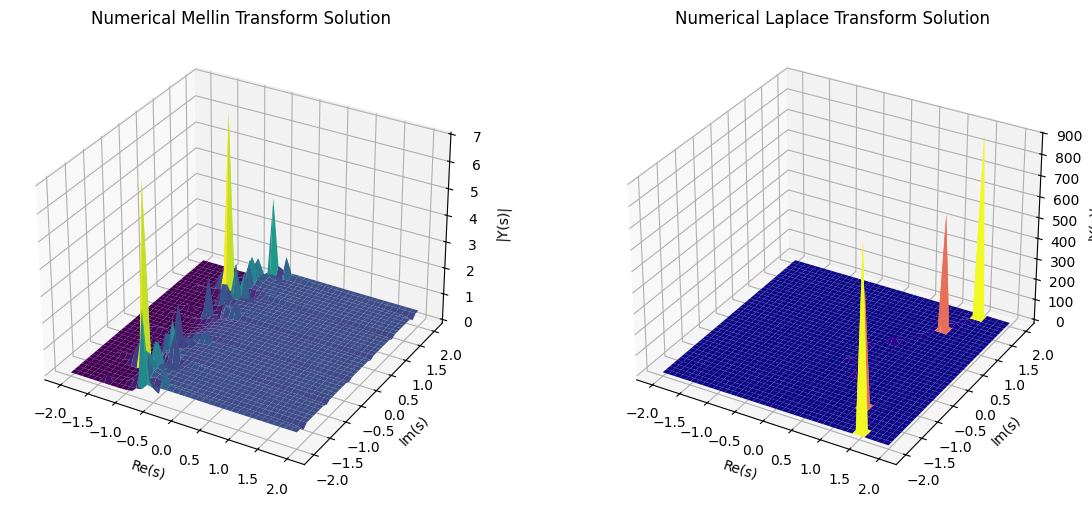

In [2]:


# === 2. Solve the Cauchy-Euler Equation Numerically ===
def cauchy_euler_ode(x, y):
    """Rewriting the second-order Cauchy-Euler equation as a system of first-order ODEs."""
    y1, y2 = y  # y1 = y, y2 = dy/dx
    dy1dx = y2
    dy2dx = (forcing_function(x) - a * x * y2 - b * y1) / (x**2 + 1e-8)  # Avoid division by zero
    return [dy1dx, dy2dx]

# Solve the system numerically over a range of x values
x_range = np.linspace(1e-6, 1e-3, 100)  # Avoid zero
sol = spi.solve_ivp(cauchy_euler_ode, [x_range[0], x_range[-1]], [1, -1], t_eval=x_range)

# Interpolate the solution for smooth evaluation
y_numeric = interp.interp1d(sol.t, sol.y[0], kind='quadratic', fill_value='extrapolate')

# === 3. Compute Mellin and Laplace Transforms ===
def numerical_derivative(func, x, order=1, dx=1e-5):
    """Compute numerical derivative using finite differences."""
    if order == 1:
        return (func(x + dx) - func(x - dx)) / (2 * dx)
    elif order == 2:
        return (func(x + dx) - 2 * func(x) + func(x - dx)) / (dx ** 2)
    else:
        raise ValueError("Only first and second derivatives supported")

def mellin_transform_numeric(func, s, x_min=1e-3, x_max=100):
    """Numerical Mellin Transform."""
    integral, _ = spi.quad(lambda x: x**(s-1) * func(x), x_min, x_max)
    return integral

def laplace_transform_numeric(func, s, x_min=0, x_max=100):
    """Numerical Laplace Transform."""
    integral, _ = spi.quad(lambda x: np.exp(-s*x) * func(x), x_min, x_max)
    return integral

# === 4. Generate Transform Data ===
s_values = np.linspace(-2, 2, 40) + 1j * np.linspace(-2, 2, 40)[:, None]

# Compute Mellin transforms of y, y', y'' numerically
mellin_y_values = np.array([[mellin_transform_numeric(y_numeric, s) for s in row] for row in s_values])
mellin_y_prime_values = np.array([[mellin_transform_numeric(lambda x: numerical_derivative(y_numeric, x, 1), s) for s in row] for row in s_values])
mellin_y_double_prime_values = np.array([[mellin_transform_numeric(lambda x: numerical_derivative(y_numeric, x, 2), s) for s in row] for row in s_values])

# Compute Laplace transforms of y, y', y'' numerically
laplace_y_values = np.array([[laplace_transform_numeric(y_numeric, s) for s in row] for row in s_values])
laplace_y_prime_values = np.array([[laplace_transform_numeric(lambda x: numerical_derivative(y_numeric, x, 1), s) for s in row] for row in s_values])
laplace_y_double_prime_values = np.array([[laplace_transform_numeric(lambda x: numerical_derivative(y_numeric, x, 2), s) for s in row] for row in s_values])

# Compute numerical transformed solutions
Y_mellin_numeric = mellin_y_values / (mellin_y_double_prime_values + a * mellin_y_prime_values + b * mellin_y_values)
Y_laplace_numeric = laplace_y_values / (laplace_y_double_prime_values + a * laplace_y_prime_values + b * laplace_y_values)

# === 5. Plot the Numerical Solutions ===
fig = plt.figure(figsize=(14, 6))

# Mellin Transform Surface
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(s_values.real, s_values.imag, np.abs(Y_mellin_numeric), cmap='viridis')
ax1.set_title("Numerical Mellin Transform Solution")
ax1.set_xlabel("Re(s)")
ax1.set_ylabel("Im(s)")
ax1.set_zlabel("|Y(s)|")

# Laplace Transform Surface
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(s_values.real, s_values.imag, np.abs(Y_laplace_numeric), cmap='plasma')
ax2.set_title("Numerical Laplace Transform Solution")
ax2.set_xlabel("Re(s)")
ax2.set_ylabel("Im(s)")
ax2.set_zlabel("|Y(s)|")

plt.show()

## now try to train NN on them and see which is easier/ better

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

# === Step 1: Define the Neural Network ===
class TransformNet(nn.Module):
    def __init__(self):
        super(TransformNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 128),  # Extra hidden layer
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)

In [4]:
def train_surface(X_values, Y_values, num_epochs=500, batch_size=32, learning_rate=0.0005):
    """
    Train a neural network on a given transformed surface.

    Parameters:
    - X_values: (N, 2) NumPy array of (Re(s), Im(s)) points.
    - Y_values: (N, 1) NumPy array of |Y(s)| values (from Mellin or Laplace).
    - num_epochs: Number of training epochs.
    - batch_size: Training batch size.
    - learning_rate: Learning rate for optimizer.

    Returns:
    - model: Trained PyTorch neural network.
    - losses: Training loss history.
    """
    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_values, dtype=torch.float32)
    Y_train_tensor = torch.tensor(Y_values, dtype=torch.float32).unsqueeze(1)

    # Create DataLoader
    dataset = TensorDataset(X_train_tensor, Y_train_tensor)
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Initialize model, optimizer, loss function
    model = TransformNet()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    # Training loop
    losses = []
    for epoch in range(num_epochs):
        total_loss = 0.0
        for batch_X, batch_Y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_Y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        losses.append(avg_loss)

        if epoch % 20 == 0:
            print(f"Epoch {epoch}: Loss = {avg_loss:.6f}")

    # Plot training loss
    plt.figure(figsize=(8, 5))
    plt.plot(range(num_epochs), losses, label="Training Loss", color='blue')
    plt.xlabel("Epochs")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.title("Training Loss Curve")
    plt.show()

    return model, losses

Epoch 0: Loss = 0.107641
Epoch 20: Loss = 0.081597
Epoch 40: Loss = 0.079178
Epoch 60: Loss = 0.077218
Epoch 80: Loss = 0.075555
Epoch 100: Loss = 0.073311
Epoch 120: Loss = 0.072388
Epoch 140: Loss = 0.064246
Epoch 160: Loss = 0.062296
Epoch 180: Loss = 0.056718
Epoch 200: Loss = 0.073333
Epoch 220: Loss = 0.070526
Epoch 240: Loss = 0.062297
Epoch 260: Loss = 0.064570
Epoch 280: Loss = 0.045817
Epoch 300: Loss = 0.060606
Epoch 320: Loss = 0.030842
Epoch 340: Loss = 0.070020
Epoch 360: Loss = 0.025293
Epoch 380: Loss = 0.031110
Epoch 400: Loss = 0.013995
Epoch 420: Loss = 0.022322
Epoch 440: Loss = 0.073056
Epoch 460: Loss = 0.035199
Epoch 480: Loss = 0.030286


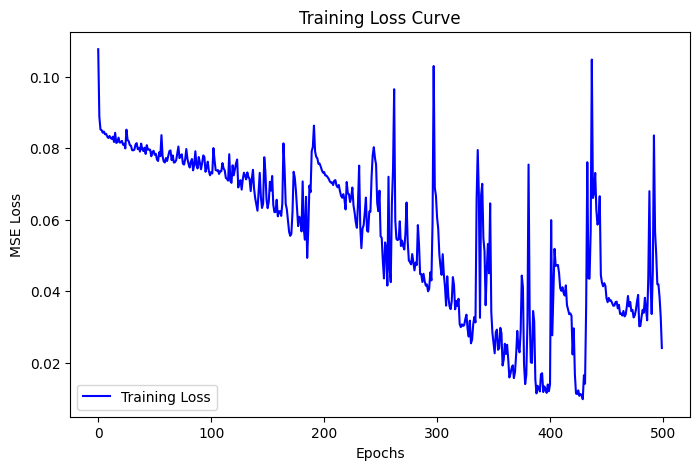

In [5]:
# Example: Train on the Mellin Transform Surface
X_mellin = np.column_stack((s_values.real.flatten(), s_values.imag.flatten()))
Y_mellin = np.abs(Y_mellin_numeric.flatten())

model_mellin, losses_mellin = train_surface(X_mellin, Y_mellin)

Epoch 0: Loss = 1374.610291
Epoch 20: Loss = 1350.550337
Epoch 40: Loss = 1327.762826
Epoch 60: Loss = 1290.131959
Epoch 80: Loss = 1270.593567
Epoch 100: Loss = 1273.786376
Epoch 120: Loss = 1229.016104
Epoch 140: Loss = 1211.516768
Epoch 160: Loss = 1197.268754
Epoch 180: Loss = 1197.426874
Epoch 200: Loss = 1174.839700
Epoch 220: Loss = 1162.595336
Epoch 240: Loss = 1149.491268
Epoch 260: Loss = 1093.031455
Epoch 280: Loss = 1050.704059
Epoch 300: Loss = 990.826837
Epoch 320: Loss = 1020.196638
Epoch 340: Loss = 976.274448
Epoch 360: Loss = 986.685929
Epoch 380: Loss = 783.612627
Epoch 400: Loss = 914.518752
Epoch 420: Loss = 1000.199427
Epoch 440: Loss = 1018.108641
Epoch 460: Loss = 946.964146
Epoch 480: Loss = 887.097119


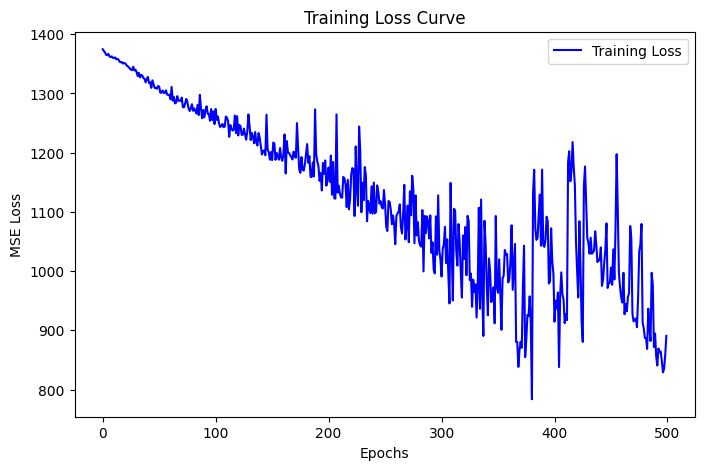

In [6]:


# Example: Train on the Laplace Transform Surface
X_laplace = np.column_stack((s_values.real.flatten(), s_values.imag.flatten()))
Y_laplace = np.abs(Y_laplace_numeric.flatten())

model_laplace, losses_laplace = train_surface(X_laplace, Y_laplace)

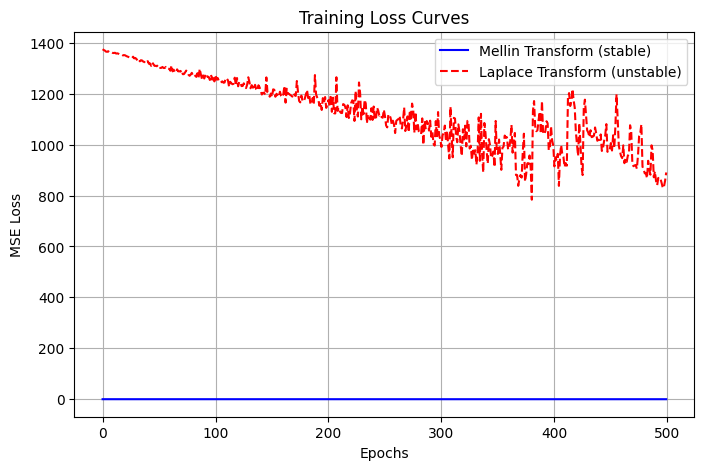

In [7]:
import matplotlib.pyplot as plt

# Example: Assume num_epochs is defined (e.g., 500)
epochs = range(500)

plt.figure(figsize=(8, 5))
plt.plot(epochs, losses_mellin, label="Mellin Transform (stable)", color="blue", linestyle="-")
plt.plot(epochs, losses_laplace, label="Laplace Transform (unstable)", color="red", linestyle="--")

plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("Training Loss Curves")
plt.legend()
plt.grid(True)
plt.show()

In [8]:
torch.save(model_mellin.state_dict(), "model_mellin.pth")
torch.save(model_laplace.state_dict(), "model_laplace.pth")

In [9]:
# Recreate the model architecture
model_mellin = TransformNet()
model_laplace = TransformNet()

# Load the saved weights
model_mellin.load_state_dict(torch.load("model_mellin.pth"))
model_laplace.load_state_dict(torch.load("model_laplace.pth"))

# Set to evaluation mode
model_mellin.eval()
model_laplace.eval()

<ipython-input-9-6f83b5bdaf60>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_mellin.load_state_dict(torch.load("model_mellin.pth"))
<ipython-input-9-6f83b5bdaf60>:7

TransformNet(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=1, bias=True)
  )
)

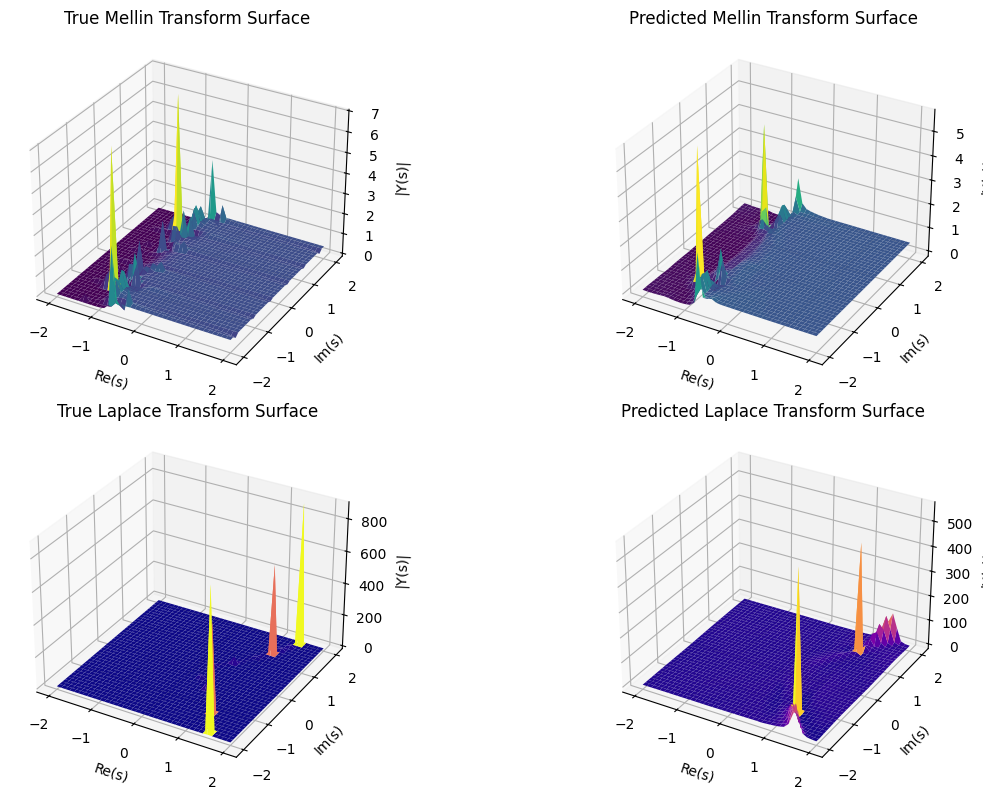

In [10]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Function to generate predictions from the trained network
def predict_surface(model, X_values):
    """Generate predictions from a trained neural network."""
    with torch.no_grad():
        X_tensor = torch.tensor(X_values, dtype=torch.float32)
        Y_pred = model(X_tensor).numpy().reshape(s_values.shape)  # Reshape to match original surface
    return Y_pred

# Prepare input for predictions
X_mellin = np.column_stack((s_values.real.flatten(), s_values.imag.flatten()))
X_laplace = np.column_stack((s_values.real.flatten(), s_values.imag.flatten()))

# Predict Mellin and Laplace surfaces using trained models
Y_mellin_pred = predict_surface(model_mellin, X_mellin)
Y_laplace_pred = predict_surface(model_laplace, X_laplace)

# === Plot comparison: True vs. Predicted surfaces ===
fig = plt.figure(figsize=(14, 8))

# True Mellin Transform Surface
ax1 = fig.add_subplot(221, projection='3d')
ax1.plot_surface(s_values.real, s_values.imag, np.abs(Y_mellin_numeric), cmap='viridis')
ax1.set_title("True Mellin Transform Surface")
ax1.set_xlabel("Re(s)")
ax1.set_ylabel("Im(s)")
ax1.set_zlabel("|Y(s)|")

# Predicted Mellin Transform Surface
ax2 = fig.add_subplot(222, projection='3d')
ax2.plot_surface(s_values.real, s_values.imag, Y_mellin_pred, cmap='viridis')
ax2.set_title("Predicted Mellin Transform Surface")
ax2.set_xlabel("Re(s)")
ax2.set_ylabel("Im(s)")
ax2.set_zlabel("|Y(s)|")

# True Laplace Transform Surface
ax3 = fig.add_subplot(223, projection='3d')
ax3.plot_surface(s_values.real, s_values.imag, np.abs(Y_laplace_numeric), cmap='plasma')
ax3.set_title("True Laplace Transform Surface")
ax3.set_xlabel("Re(s)")
ax3.set_ylabel("Im(s)")
ax3.set_zlabel("|Y(s)|")

# Predicted Laplace Transform Surface
ax4 = fig.add_subplot(224, projection='3d')
ax4.plot_surface(s_values.real, s_values.imag, Y_laplace_pred, cmap='plasma')
ax4.set_title("Predicted Laplace Transform Surface")
ax4.set_xlabel("Re(s)")
ax4.set_ylabel("Im(s)")
ax4.set_zlabel("|Y(s)|")

plt.tight_layout()
plt.show()